# Artificial Neural Network & Random Forest Modelling

### Main Research Question:

How should movie studios design their strategy to maximize the profit of their movies?

### Subquestions:

1 - Which model performs best at predicting profit?

2 - How do certain genre affect the movie´s profit?

2 - How do certain ratings affect the movie´s profit?

3 - How does the production budget influence the profit of the movies?

4 - How does the theatre count influence the profit of a movie?

5 - How does the release month influence the profit?

6 - How does the runtime influence the profit of a movie?

# Table of contents 

###  Import libraries 

###  1. Creating the train, test, and validation splits & encoding
          
###  2. Encoding & Scaling 
         2.1 Train dataset
         2.2 Test dataset
         2.3 Validation dataset

###  3. Data Concatenation and Quality Check for Training-Validation Sets

###  4. Modelling
        4.1 Random forest
            4.1.1 Fitting model & hyperparametertuning
            4.1.2 Testing the model
        4.2 Artificial Neural Network
            4.2.1 Fitting the training dataset
            4.2.2 Evaluate on validation dataset
            4.2.3 Train model on train & validation dataset and make predictions on test set
            4.2.4 Hyperparametertuning
            4.2.5 Evaluate model on test dataset
###  5. Explainability




In [1]:
# importing useful libraries 
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from IPython.core.interactiveshell import InteractiveShell
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from plotnine import ggplot, aes, geom_point



import matplotlib.pyplot as plt
import os
import datetime
import pickle
import json
import random
import re

import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
from tensorflow.keras.optimizers import Adam
import keras
print('keras: %s' % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier


tensorflow: 2.15.0
keras: 2.12.0


In [2]:
#declaring constants for model behavior
USE_STORED_SVC_HYPERTUNED_MODELS = True
USE_STORED_SVC_SKLEARNED_HYPERTUNED_MODELS = True
USE_STORED_NN_HYPERTUNED_MODELS = True

In [3]:
# Loading the CSV file into a pandas DataFrame
file_path = r"c:\Users\leath\Documents\AUAS\0. Completed\7. AI Methods in Business\Resit\Merged_Cleaned.csv"
merged_df = pd.read_csv(file_path)

# Showing dataframe
merged_df.head()

,rating,metascore,userscore,Age,RelMonth,top_actors_count,genre,worldwide_box_office,production_budget,theatre_count,avg run per theatre,runtime,profit
0,PG-13,76,7.700,8,3,1,Thriller/Suspense,1.082864e+08,1.500000e+07,3391.00000,4.900000,103.0,9.328642e+07
1,R,61,6.900,12,9,0,Drama,9.876400e+05,3.642238e+07,3.00000,2.100000,100.0,-3.543474e+07
2,Not Rated,63,7.500,11,6,0,Comedy,2.524796e+07,3.642238e+07,13.00000,1.500000,91.0,-1.117442e+07
3,Not Rated,44,6.100,7,1,0,Drama,3.070000e+02,3.642238e+07,723.14704,4.124562,93.0,-3.642208e+07
4,Not Rated,65,6.886,9,5,0,Drama,4.701900e+04,3.642238e+07,723.14704,4.124562,88.0,-3.637536e+07


Only the features with a correlation of more than 0.2 with profit (please see Sales Cleaning file) and the categorical values are chosen for this modelling.

In [4]:
# Removing columns
merged_df.drop(['worldwide_box_office', 'metascore', 'userscore', 'Age', 'RelMonth', 'top_actors_count'], inplace=True, axis=1)

Rating is encoded before as an error was given when doing it together with the genre in the next step.

In [5]:
from sklearn.preprocessing import OneHotEncoder

# Columns for One-Hot Encoding
columns_to_encode = ['rating']

# Extract the columns to be encoded
data_to_encode = merged_df[columns_to_encode]

# Create the OneHotEncoder instance
one_hot_encoder = OneHotEncoder(sparse=False, drop='first')

# Fit and transform the data using the encoder
encoded_data = one_hot_encoder.fit_transform(data_to_encode)

# Get the feature names after encoding
encoded_column_names = one_hot_encoder.get_feature_names_out(columns_to_encode)

# Create a DataFrame with the encoded data and appropriate column names
encoded_df = pd.DataFrame(encoded_data, columns=encoded_column_names)

# Concatenate the encoded DataFrame with the original DataFrame
merged_df = pd.concat([merged_df.drop(columns=columns_to_encode), encoded_df], axis=1)

# Display the updated DataFrame with encoded columns
merged_df.head()

c:\Users\leath\anaconda3\python\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


,genre,production_budget,theatre_count,avg run per theatre,runtime,profit,rating_ G,rating_ M/PG,rating_ MA-17,rating_ NC-17,rating_ NR,rating_ Not Rated,rating_ PG-13,rating_ R,rating_ TV-14,rating_ TV-G,rating_ TV-MA,rating_ TV-PG
0,Thriller/Suspense,1.500000e+07,3391.00000,4.900000,103.0,9.328642e+07,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Drama,3.642238e+07,3.00000,2.100000,100.0,-3.543474e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Comedy,3.642238e+07,13.00000,1.500000,91.0,-1.117442e+07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Drama,3.642238e+07,723.14704,4.124562,93.0,-3.642208e+07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Drama,3.642238e+07,723.14704,4.124562,88.0,-3.637536e+07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# 1. Creating the train, test, and validation splits & encoding

In [6]:
# Display the data types of each column
print(merged_df.dtypes)

genre                   object
production_budget      float64
theatre_count          float64
avg run per theatre    float64
runtime                float64
profit                 float64
rating_ G              float64
rating_ M/PG           float64
rating_ MA-17          float64
rating_ NC-17          float64
rating_ NR             float64
rating_ Not Rated      float64
rating_ PG-13          float64
rating_ R              float64
rating_ TV-14          float64
rating_ TV-G           float64
rating_ TV-MA          float64
rating_ TV-PG          float64
dtype: object


In [7]:
# Splitting the df in 20% testing and 80% fitting data points.
# Specify the categorical columns
categorical_columns = ['genre']
X = merged_df.drop(['profit'], axis=1)
y = merged_df['profit']

# Splitting the dataset into training and testing sets into 80% training and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Further splitting  the fitting set into training and validation sets (80% train, 20% validation)
# # This means 80% of the fitting dataset is used for training and 20% for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create an instance of OneHotEncoder
one_hot_encoder = OneHotEncoder()

# Fit the encoder on the categorical columns of the training data
one_hot_encoder.fit(X_train[categorical_columns])

# Transform the training and testing data
X_train_encoded = one_hot_encoder.transform(X_train[categorical_columns]).toarray()
X_val_encoded= one_hot_encoder.transform(X_val[categorical_columns]).toarray()
X_test_encoded = one_hot_encoder.transform(X_test[categorical_columns]).toarray()

# Retrieve the names of the new dummy columns that have been computed
encoded_names = one_hot_encoder.get_feature_names_out()

# Create DataFrames from the encoded categories
df_X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoded_names)
df_X_val_encoded = pd.DataFrame(X_val_encoded, columns=encoded_names)
df_X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoded_names)


# 2. Encoding & Scaling 

## 2.1 Train dataset

In [8]:
# Preparing the X_train data
# Display the first few rows of the encoded DataFrame for the training data
df_X_train_encoded.head()

# Drop the original categorical columns from the training data
X_train_dropped = X_train.drop(columns=categorical_columns)

# Concatenate the training data with the new one-hot encoded columns
X_train_set = pd.concat([df_X_train_encoded.reset_index(drop=True), X_train_dropped.reset_index(drop=True)], axis=1)

# Display the first few rows of the final training DataFrame
X_train_set.head()

,genre_Action/Adventure,genre_Comedy,genre_Documentary,genre_Drama,genre_Horror,genre_Other,genre_Thriller/Suspense,genre_Unknown,production_budget,theatre_count,...,rating_ MA-17,rating_ NC-17,rating_ NR,rating_ Not Rated,rating_ PG-13,rating_ R,rating_ TV-14,rating_ TV-G,rating_ TV-MA,rating_ TV-PG
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.642238e+07,723.14704,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.000000e+07,5.00000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.642238e+07,1.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.000000e+06,2700.00000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.642238e+07,51.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Display all column names
print("Column names:")
print(X_train_set.columns)

Column names:
Index(['genre_Action/Adventure', 'genre_Comedy', 'genre_Documentary',
       'genre_Drama', 'genre_Horror', 'genre_Other', 'genre_Thriller/Suspense',
       'genre_Unknown', 'production_budget', 'theatre_count',
       'avg run per theatre', 'runtime', 'rating_ G', 'rating_ M/PG',
       'rating_ MA-17', 'rating_ NC-17', 'rating_ NR', 'rating_ Not Rated',
       'rating_ PG-13', 'rating_ R', 'rating_ TV-14', 'rating_ TV-G',
       'rating_ TV-MA', 'rating_ TV-PG'],
      dtype='object')


In [10]:
# Scaling the X_train data
# Initialize the StandardScaler
standard_scaler = StandardScaler()

# Columns to be scaled
columns_to_scale = ['genre_Action/Adventure', 'genre_Comedy', 'genre_Documentary', 
       'genre_Drama', 'genre_Horror', 'genre_Other', 'genre_Thriller/Suspense',
       'genre_Unknown', 'production_budget', 'theatre_count',
       'avg run per theatre', 'runtime', 'rating_ G', 'rating_ M/PG',
       'rating_ MA-17', 'rating_ NC-17', 'rating_ NR', 'rating_ Not Rated',
       'rating_ PG-13', 'rating_ R', 'rating_ TV-14', 'rating_ TV-G',
       'rating_ TV-MA', 'rating_ TV-PG']

# Fit the scaler on the specified columns of the training data
standard_scaler.fit(X_train_set[columns_to_scale])

# Transform these columns in the training set
X_train_scaled_columns = standard_scaler.transform(X_train_set[columns_to_scale])

# Replace the original columns in train_set with their scaled versions
X_train_set[columns_to_scale] = X_train_scaled_columns

# Displaying the X_train data
X_train_set.head()

,genre_Action/Adventure,genre_Comedy,genre_Documentary,genre_Drama,genre_Horror,genre_Other,genre_Thriller/Suspense,genre_Unknown,production_budget,theatre_count,...,rating_ MA-17,rating_ NC-17,rating_ NR,rating_ Not Rated,rating_ PG-13,rating_ R,rating_ TV-14,rating_ TV-G,rating_ TV-MA,rating_ TV-PG
0,-0.374192,2.049213,-0.427520,-0.670171,-0.247771,-0.126211,-0.337512,-0.216058,-0.045672,-0.184831,...,0.0,-0.067455,-0.111912,1.454709,-0.512492,-0.730711,-0.05287,-0.022867,-0.115836,-0.039628
1,-0.374192,-0.487992,-0.427520,-0.670171,-0.247771,7.923243,-0.337512,-0.216058,-0.586615,-0.771363,...,0.0,-0.067455,-0.111912,-0.687423,1.951248,-0.730711,-0.05287,-0.022867,-0.115836,-0.039628
2,-0.374192,-0.487992,2.339071,-0.670171,-0.247771,-0.126211,-0.337512,-0.216058,-0.045672,-0.774630,...,0.0,-0.067455,-0.111912,1.454709,-0.512492,-0.730711,-0.05287,-0.022867,-0.115836,-0.039628
3,-0.374192,-0.487992,-0.427520,-0.670171,4.035983,-0.126211,-0.337512,-0.216058,-1.113645,1.429723,...,0.0,-0.067455,-0.111912,-0.687423,1.951248,-0.730711,-0.05287,-0.022867,-0.115836,-0.039628
4,-0.374192,-0.487992,-0.427520,1.492157,-0.247771,-0.126211,-0.337512,-0.216058,-0.045672,-0.733794,...,0.0,-0.067455,-0.111912,1.454709,-0.512492,-0.730711,-0.05287,-0.022867,-0.115836,-0.039628


In [11]:
# Scaling the y_train data
# Reshaping the values
y_train.values.reshape(-1, 1)
# Initialize the StandardScaler
standard_scaler.fit(y_train.values.reshape(-1, 1))

# Transform these columns in the training set &  replace the original columns in train_set with their scaled versions
y_train_set = standard_scaler.transform(y_train.values.reshape(-1, 1))
y_train_set

array([[-0.24984327],
       [ 3.50370332],
       [-0.24984327],
       ...,
       [-0.24984327],
       [-0.22627701],
       [-0.24984327]])

## 2.2 Validation dataset

In [12]:
# Preparing the X_val data
# Display the first few rows of the encoded DataFrame for the validation data
df_X_val_encoded.head()

# Drop the original categorical columns from the validation data
X_val_dropped = X_val.drop(columns=categorical_columns)

# Concatenate the validation data with the new one-hot encoded columns
X_val_set = pd.concat([df_X_val_encoded.reset_index(drop=True), X_val_dropped.reset_index(drop=True)], axis=1)

# Display the first few rows of the final validation DataFrame
X_val_set.head()

,genre_Action/Adventure,genre_Comedy,genre_Documentary,genre_Drama,genre_Horror,genre_Other,genre_Thriller/Suspense,genre_Unknown,production_budget,theatre_count,...,rating_ MA-17,rating_ NC-17,rating_ NR,rating_ Not Rated,rating_ PG-13,rating_ R,rating_ TV-14,rating_ TV-G,rating_ TV-MA,rating_ TV-PG
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.642238e+07,2.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.800000e+07,1858.00000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.800000e+07,3594.00000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.642238e+07,723.14704,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.642238e+07,3.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Scaling the X_val data
# Initialize the StandardScaler
standard_scaler = StandardScaler()

# Columns to be scaled
columns_to_scale = ['genre_Action/Adventure', 'genre_Comedy', 'genre_Documentary', 
       'genre_Drama', 'genre_Horror', 'genre_Other', 'genre_Thriller/Suspense',
       'genre_Unknown', 'production_budget', 'theatre_count',
       'avg run per theatre', 'runtime', 'rating_ G', 'rating_ M/PG',
       'rating_ MA-17', 'rating_ NC-17', 'rating_ NR', 'rating_ Not Rated',
       'rating_ PG-13', 'rating_ R', 'rating_ TV-14', 'rating_ TV-G',
       'rating_ TV-MA', 'rating_ TV-PG']

# Fit the scaler on the specified columns of the validation data
standard_scaler.fit(X_val_set[columns_to_scale])

# Transform these columns in the validation set
X_val_scaled_columns = standard_scaler.transform(X_val_set[columns_to_scale])

# Replace the original columns in val_set with their scaled versions
X_val_set[columns_to_scale] = X_val_scaled_columns

# Displaying the X_train data
X_val_set.head()

,genre_Action/Adventure,genre_Comedy,genre_Documentary,genre_Drama,genre_Horror,genre_Other,genre_Thriller/Suspense,genre_Unknown,production_budget,theatre_count,...,rating_ MA-17,rating_ NC-17,rating_ NR,rating_ Not Rated,rating_ PG-13,rating_ R,rating_ TV-14,rating_ TV-G,rating_ TV-MA,rating_ TV-PG
0,-0.396558,2.156295,-0.425523,-0.683579,-0.257142,-0.155783,-0.316954,-0.199637,-0.042725,-0.756947,...,-0.026407,-0.064798,-0.135841,1.442012,-0.487992,-0.726788,-0.045771,0.0,-0.112707,-0.045771
1,-0.396558,2.156295,-0.425523,-0.683579,-0.257142,-0.155783,-0.316954,-0.199637,-0.659184,0.753131,...,-0.026407,-0.064798,-0.135841,-0.693475,-0.487992,1.375916,-0.045771,0.0,-0.112707,-0.045771
2,2.521701,-0.463759,-0.425523,-0.683579,-0.257142,-0.155783,-0.316954,-0.199637,0.344692,2.165574,...,-0.026407,-0.064798,-0.135841,-0.693475,2.049213,-0.726788,-0.045771,0.0,-0.112707,-0.045771
3,-0.396558,-0.463759,-0.425523,1.462889,-0.257142,-0.155783,-0.316954,-0.199637,-0.042725,-0.170208,...,-0.026407,-0.064798,-0.135841,1.442012,-0.487992,-0.726788,-0.045771,0.0,-0.112707,-0.045771
4,2.521701,-0.463759,-0.425523,-0.683579,-0.257142,-0.155783,-0.316954,-0.199637,-0.042725,-0.756133,...,-0.026407,-0.064798,-0.135841,1.442012,-0.487992,-0.726788,-0.045771,0.0,-0.112707,-0.045771


In [14]:
# Scaling the y_val data
# Reshaping the values
y_val.values.reshape(-1, 1)
# Initialize the StandardScaler
standard_scaler.fit(y_val.values.reshape(-1, 1))

# Transform these columns in the training set &  replace the original columns in train_set with their scaled versions
y_val_set = standard_scaler.transform(y_val.values.reshape(-1, 1))
y_val_set

array([[-0.22549104],
       [-0.14712269],
       [ 2.15936131],
       ...,
       [ 0.17375642],
       [-0.22549104],
       [-0.43137001]])

## 2.3 Test dataset

In [15]:
# Preparing the X_test data
# Display the first few rows of the encoded DataFrame for the training data
df_X_test_encoded.head()

# Drop the original categorical columns from the training data
X_test_dropped = X_test.drop(columns=categorical_columns)

# Concatenate the training data with the new one-hot encoded columns
X_test_set = pd.concat([X_test_dropped.reset_index(drop=True), df_X_test_encoded.reset_index(drop=True)], axis=1)

# Display the first few rows of the final training DataFrame
X_test_set.head()

,production_budget,theatre_count,avg run per theatre,runtime,rating_ G,rating_ M/PG,rating_ MA-17,rating_ NC-17,rating_ NR,rating_ Not Rated,...,rating_ TV-MA,rating_ TV-PG,genre_Action/Adventure,genre_Comedy,genre_Documentary,genre_Drama,genre_Horror,genre_Other,genre_Thriller/Suspense,genre_Unknown
0,3.642238e+07,2.00000,7.400000,82.000000,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2.000000e+08,4045.00000,6.800000,169.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.500000e+07,1751.00000,2.700000,110.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3.642238e+07,723.14704,4.124562,81.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.642238e+07,7.00000,7.800000,101.502993,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
# Scaling the X_test data
# Initialize the StandardScaler
standard_scaler = StandardScaler()

# Columns to be scaled
columns_to_scale = ['genre_Action/Adventure', 'genre_Comedy', 'genre_Documentary', 
       'genre_Drama', 'genre_Horror', 'genre_Other', 'genre_Thriller/Suspense',
       'genre_Unknown', 'production_budget', 'theatre_count',
       'avg run per theatre', 'runtime', 'rating_ G', 'rating_ M/PG',
       'rating_ MA-17', 'rating_ NC-17', 'rating_ NR', 'rating_ Not Rated',
       'rating_ PG-13', 'rating_ R', 'rating_ TV-14', 'rating_ TV-G',
       'rating_ TV-MA', 'rating_ TV-PG']

# Fit the scaler on the specified columns of the training data
standard_scaler.fit(X_test_set[columns_to_scale])

# Transform these columns in the training set
X_test_scaled_columns = standard_scaler.transform(X_test_set[columns_to_scale])

# Replace the original columns in test_set with their scaled versions
X_test_set[columns_to_scale] = X_test_scaled_columns

# Displaying the X_train data
X_test_set.head()

StandardScaler()

,production_budget,theatre_count,avg run per theatre,runtime,rating_ G,rating_ M/PG,rating_ MA-17,rating_ NC-17,rating_ NR,rating_ Not Rated,...,rating_ TV-MA,rating_ TV-PG,genre_Action/Adventure,genre_Comedy,genre_Documentary,genre_Drama,genre_Horror,genre_Other,genre_Thriller/Suspense,genre_Unknown
0,-0.041748,-0.797880,1.156449,-1.361141,-0.085436,-0.293183,-7.450581e-09,-0.047272,-0.097809,1.478682,...,-0.118879,-0.033408,-0.376760,-0.468592,2.423544,-0.684167,-0.265341,-0.145116,-0.325641,-0.227118
1,5.426458,2.443542,0.923461,4.392246,-0.085436,-0.293183,-7.450581e-09,-0.047272,-0.097809,-0.676278,...,-0.118879,-0.033408,2.654212,-0.468592,-0.412619,-0.684167,-0.265341,-0.145116,-0.325641,-0.227118
2,-0.757873,0.604357,-0.668625,0.490524,-0.085436,-0.293183,-7.450581e-09,-0.047272,-0.097809,-0.676278,...,-0.118879,-0.033408,-0.376760,-0.468592,-0.412619,-0.684167,-0.265341,-0.145116,3.070868,-0.227118
3,-0.041748,-0.219710,-0.115449,-1.427272,-0.085436,-0.293183,-7.450581e-09,-0.047272,-0.097809,-0.676278,...,-0.118879,-0.033408,-0.376760,2.134052,-0.412619,-0.684167,-0.265341,-0.145116,-0.325641,-0.227118
4,-0.041748,-0.793872,1.311774,-0.071391,-0.085436,-0.293183,-7.450581e-09,-0.047272,-0.097809,-0.676278,...,-0.118879,-0.033408,-0.376760,2.134052,-0.412619,-0.684167,-0.265341,-0.145116,-0.325641,-0.227118


In [17]:
# Scaling the y_test data
# Reshaping the values
y_test.values.reshape(-1, 1)
# Initialize the StandardScaler
standard_scaler.fit(y_test.values.reshape(-1, 1))

# Transform these columns in the training set & replace the original columns in test_set with their scaled versions
y_test_set = standard_scaler.transform(y_test.values.reshape(-1, 1))
y_test_set

array([[-0.44757312],
       [ 6.27346098],
       [-0.13501882],
       ...,
       [-0.24899046],
       [-0.42454713],
       [-0.18821449]])

# 3. Data Concatenation and Quality Check for Training-Validation Sets

In [18]:
# Concatenate training and validation features along the rows, resetting index to avoid duplicate indices
X_train_validation = pd.concat([X_train_set.reset_index(drop=True), X_val_set.reset_index(drop=True)], axis=0)

# Concatenate training and validation target variables using NumPy
y_train_validation = np.concatenate([y_train_set, y_val_set], axis=0)

# Check for any null (missing) values in the concatenated features
x_null_check = X_train_validation.isnull().values.any()

# Check for any NaN (Not a Number) values in the concatenated target variable
y_null_check = np.isnan(y_train_validation).any()

In [19]:
# Get the column order from 'X_test'
column_order = X_test_set.columns.tolist()

# Reorder 'X_train_validation' to match 'X_test'
X_train_validation = X_train_validation[column_order]

In [20]:
# Convert the y_train_validation NumPy array to a pandas DataFrame
y_train_validation_df = pd.DataFrame(y_train_validation, columns=['profit'])

# Display the DataFrame
y_train_validation_df

,profit
0,-0.249843
1,3.503703
2,-0.249843
3,0.032915
4,-0.249843
...,...
7170,-0.141440
7171,1.184436
7172,0.173756
7173,-0.225491


# 4. Modelling

## 4.1 Random Forest

### 4.1.1 Fitting model & hyperparametertuning

In [21]:
X_train_validation

,production_budget,theatre_count,avg run per theatre,runtime,rating_ G,rating_ M/PG,rating_ MA-17,rating_ NC-17,rating_ NR,rating_ Not Rated,...,rating_ TV-MA,rating_ TV-PG,genre_Action/Adventure,genre_Comedy,genre_Documentary,genre_Drama,genre_Horror,genre_Other,genre_Thriller/Suspense,genre_Unknown
0,-0.045672,-0.184831,-0.082963,-1.169015,-0.107852,-0.287420,0.000000,-0.067455,-0.111912,1.454709,...,-0.115836,-0.039628,-0.374192,2.049213,-0.427520,-0.670171,-0.247771,-0.126211,-0.337512,-0.216058
1,-0.586615,-0.771363,1.046265,1.442514,-0.107852,-0.287420,0.000000,-0.067455,-0.111912,-0.687423,...,-0.115836,-0.039628,-0.374192,-0.487992,-0.427520,-0.670171,-0.247771,7.923243,-0.337512,-0.216058
2,-0.045672,-0.774630,-0.312287,-0.998698,-0.107852,-0.287420,0.000000,-0.067455,-0.111912,1.454709,...,-0.115836,-0.039628,-0.374192,-0.487992,2.339071,-0.670171,-0.247771,-0.126211,-0.337512,-0.216058
3,-1.113645,1.429723,-0.569311,-0.828381,-0.107852,-0.287420,0.000000,-0.067455,-0.111912,-0.687423,...,-0.115836,-0.039628,-0.374192,-0.487992,-0.427520,-0.670171,4.035983,-0.126211,-0.337512,-0.216058
4,-0.045672,-0.733794,-0.202135,-0.714836,-0.107852,-0.287420,0.000000,-0.067455,-0.111912,1.454709,...,-0.115836,-0.039628,-0.374192,-0.487992,-0.427520,1.492157,-0.247771,-0.126211,-0.337512,-0.216058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,-1.194585,-0.716266,-0.473307,-0.084651,-0.115836,-0.302084,-0.026407,-0.064798,-0.135841,-0.693475,...,-0.112707,-0.045771,-0.396558,-0.463759,-0.425523,1.462889,-0.257142,-0.155783,-0.316954,-0.199637
1431,-0.592259,-0.743115,2.622169,1.870917,-0.115836,-0.302084,-0.026407,-0.064798,-0.135841,-0.693475,...,-0.112707,-0.045771,-0.396558,-0.463759,-0.425523,1.462889,-0.257142,-0.155783,-0.316954,-0.199637
1432,0.244304,1.379617,-0.191900,1.684655,-0.115836,-0.302084,-0.026407,-0.064798,-0.135841,-0.693475,...,-0.112707,-0.045771,-0.396558,-0.463759,-0.425523,-0.683579,-0.257142,-0.155783,3.155027,-0.199637
1433,-0.042725,-0.170208,-0.101624,-1.419717,-0.115836,-0.302084,-0.026407,-0.064798,-0.135841,-0.693475,...,-0.112707,-0.045771,-0.396558,-0.463759,-0.425523,1.462889,-0.257142,-0.155783,-0.316954,-0.199637


In [22]:
column_list = X_train_validation.columns.tolist()
print(column_list)

['production_budget', 'theatre_count', 'avg run per theatre', 'runtime', 'rating_ G', 'rating_ M/PG', 'rating_ MA-17', 'rating_ NC-17', 'rating_ NR', 'rating_ Not Rated', 'rating_ PG-13', 'rating_ R', 'rating_ TV-14', 'rating_ TV-G', 'rating_ TV-MA', 'rating_ TV-PG', 'genre_Action/Adventure', 'genre_Comedy', 'genre_Documentary', 'genre_Drama', 'genre_Horror', 'genre_Other', 'genre_Thriller/Suspense', 'genre_Unknown']


Grid Search will be done on the follwoing hyperparameters:

n_estimators: Number of trees in the forest

max_depth: Maximum depth (splits) of the individual decision trees

min_samples_split: Minimum number of samples (datapoints) required to split an internal node.

min_samples_leaf: Minimum number of samples (datapoints) required to be at a leaf node.

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Your RandomForestRegressor definition
rf = RandomForestRegressor(n_jobs=-1, random_state=1)

# Hyperparameter grid for finer search
param_grid_finer = {
    "n_estimators": [x for x in range(10, 200, 10)],
    "max_depth": [x for x in range(5, 21, 5)],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Create a GridSearchCV object with RandomForestRegressor
grid_search_rf_finer = GridSearchCV(
    rf,
    param_grid=param_grid_finer,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=5  # Number of cross-validation folds
)

# Fit the model
_ = grid_search_rf_finer.fit(X_train_validation, y_train_validation)

# Get the best estimator and score
best_estimator_finer = grid_search_rf_finer.best_estimator_
best_score_finer = grid_search_rf_finer.best_score_

# Output the results
print("Best Estimator (Finer Grid):", best_estimator_finer)
print("Best Score (Finer Grid):", best_score_finer)

c:\Users\leath\anaconda3\python\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Best Estimator (Finer Grid): RandomForestRegressor(max_depth=15, n_estimators=130, n_jobs=-1, random_state=1)
Best Score (Finer Grid): -0.2172044033489448


With the best hyperparameters found, the model will be tested.

### 4.1.2 Testing the model

As the problem is a regression problem, evaluation metrics such as Mean Squared Error, Mean Absolute Error, Root Mean Squared Error and R-Aquared Error will be used.

Mean Squared Error (MSE):
    MSE measures the average squared difference between the actual and predicted values.
        
Mean Absolute Error (MAE):
    MAE measures the average absolute difference between the actual and predicted values.

Root Mean Squared Error (RMSE):
    RMSE is the square root of the MSE and provides an interpretable scale similar to the original target variable.

R-squared (R²):
    R² represents the proportion of the variance in the dependent variable that is predictable from the independent variable(s).

In [24]:
from sklearn.model_selection import GridSearchCV

# Predictions using the trained Random Forest model on the test set
y_hat_test = grid_search_rf_finer.predict(X_test_set)

# Transforming predicted and actual values back to the original scale using inverse scaling
y_test_set_original_scale = standard_scaler.inverse_transform(y_test_set.reshape(-1, 1)).flatten()
y_hat_test_original_scale = standard_scaler.inverse_transform(y_hat_test.reshape(-1, 1)).flatten()

# Calculate Mean Squared Error (MSE) between actual and predicted values
mse = mean_squared_error(y_test_set_original_scale, y_hat_test_original_scale)
print("Mean Squared Error:", mse)

# Calculate Mean Absolute Error (MAE) between actual and predicted values
mae = mean_absolute_error(y_test_set_original_scale, y_hat_test_original_scale)
print("Mean Absolute Error:", mae)

# Calculate Root Mean Squared Error (RMSE) between actual and predicted values
rmse = np.sqrt(mean_squared_error(y_test_set_original_scale, y_hat_test_original_scale))
print("Root Mean Squared Error:", rmse)

# Calculate R-squared (coefficient of determination) between actual and predicted values
r_squared = r2_score(y_test_set_original_scale, y_hat_test_original_scale)
print("R-squared:", r_squared)

Mean Squared Error: 5275314645450592.0
Mean Absolute Error: 25880722.45275615
Root Mean Squared Error: 72631361.30798177
R-squared: 0.6711550318929789


Mean Squared Error: 5275314645450592.0

Mean Absolute Error: 25880722.45275615

Root Mean Squared Error: 72631361.30798177

R-squared: 0.6711550318929789

# revise!!!!!

Conclusion:

Mean Squared Error (MSE):
        The large MSE value indicates that, on average, the squared differences between the actual and predicted profit values are substantial. This suggests that the model may have difficulty accurately predicting the precise numerical values of profit figures.

Mean Absolute Error (MAE):
        The MAE value suggests that, on average, the model's predictions are about 2,386,101 units away from the actual profit values. While this is a significant amount, the profit range is pretty wide, ranging between a min of 158,089,800 and a max of 2,608,900,000.

Root Mean Squared Error (RMSE):
        The RMSE value indicates the standard deviation of the prediction errors. This suggests that the majority of the model's prediction errors fall within ±19,661,008 units of the actual profit values. 

R-squared (R²):
        The R² value of 0.9759 indicates that the model explains approximately 97.59% of the variability in the profit data. While this suggests a reasonable fit, there is still a considerable portion of unexplained variability.

In [25]:
# Putting the results in context 
# Getting more information about the data
merged_df['profit'].describe()

count    8.969000e+03
mean     1.798105e+07
std      1.187871e+08
min     -1.580898e+08
25%     -2.852238e+07
50%     -1.117442e+07
75%      9.767275e+06
max      2.608900e+09
Name: profit, dtype: float64

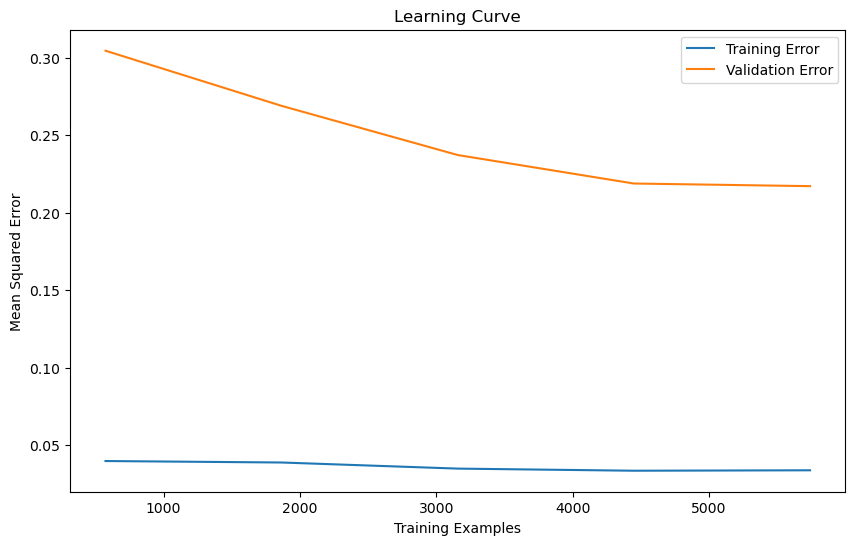

In [26]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv, train_sizes=np.linspace(.1, 1.0, 5)):
    
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='neg_mean_squared_error', n_jobs=-1
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    validation_scores_mean = -np.mean(validation_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Error')
    plt.plot(train_sizes, validation_scores_mean, label='Validation Error')

    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()

# Assuming you have your RandomForestRegressor 'best_estimator', X_train, and y_train_validation
plot_learning_curve(best_estimator_finer, X_train_validation, y_train_validation, cv=5)

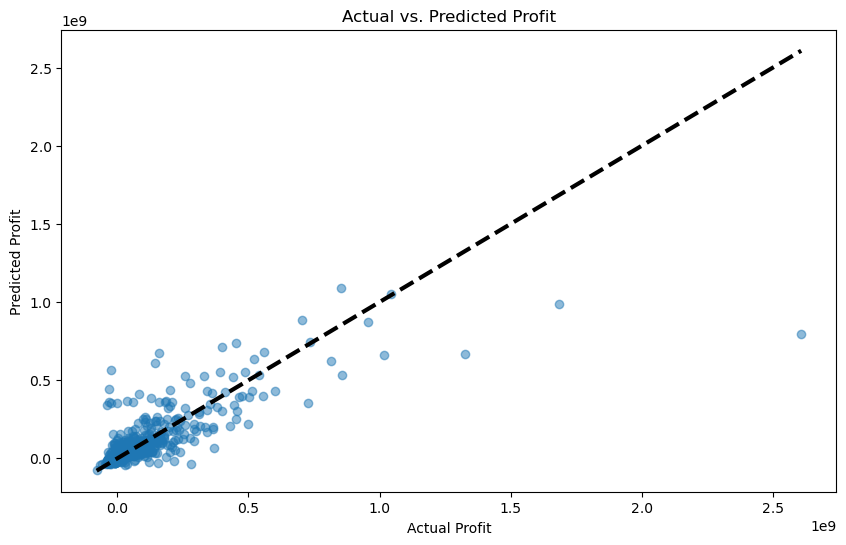

In [27]:
# Plotting the results
# Inverse transform to original scale
y_test_set_original = standard_scaler.inverse_transform(y_test_set.reshape(-1, 1)).flatten()
y_hat_test_original = standard_scaler.inverse_transform(y_hat_test.reshape(-1, 1)).flatten()

# Scatter plot of Actual vs. Predicted values on original scale
plt.figure(figsize=(10, 6))
plt.scatter(y_test_set_original, y_hat_test_original, alpha=0.5)
plt.title('Actual vs. Predicted Profit')
plt.xlabel('Actual Profit')
plt.ylabel('Predicted Profit')

# Plot a line for perfect predictions
plt.plot([y_test_set_original.min(), y_test_set_original.max()], 
         [y_test_set_original.min(), y_test_set_original.max()], 'k--', lw=3)
plt.show()

**Conclusion:** The predicted values seem to be really close to the actual values. The lower the values, the more accurate the prediction. The two highest values are the least accurate. Removing this datapoint(s) as outliers would probably lead to a higher accuracy of the model.

## 4.2 Artificial Neural Network

In [28]:
print(f"The number of neurons for the input layer must be: {X_train_set.shape[1]}")

The number of neurons for the input layer must be: 24


In [29]:
from keras import regularizers

# Define the neural network model class instance
# Create the model
simple_nn = Sequential()

# Add the first layer with L2 regularization
simple_nn.add(Dense(64, input_dim=X_train_set.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.03))) 

# Adding a hidden layer with L2 regularization
simple_nn.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.03)))  

# Adding a hidden layer with L2 regularization
simple_nn.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.03)))  

# Add the output layer
simple_nn.add(Dense(1, activation='linear'))

# Configure the Adam optimizer with a custom learning rate
adam = Adam(learning_rate=0.01)

# Compile the model
simple_nn.compile(loss='mean_squared_error', optimizer=adam)

# Print model summary
print(simple_nn.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1600      
                                                                 
 dense_1 (Dense)             (None, 256)               16640     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 150,337
Trainable params: 150,337
Non-trainable params: 0
_________________________________________________________________
None


### 4.2.1 Fitting the training dataset

In [30]:
# Checking the shape of the data
X_train_set.shape

(5740, 24)

In [31]:
y_train_set.shape

(5740, 1)

In [32]:
X_train_validation.shape

(7175, 24)

In [33]:
y_train_validation.shape

(7175, 1)

In [34]:
# Training a simple neural network using the fit method
simple_nn.fit(X_train_set, y_train_set, epochs=50, batch_size = 20)

Epoch 1/50

287/287 [==============================] - 7s 8ms/step - loss: 1.1755
Epoch 2/50
287/287 [==============================] - 3s 9ms/step - loss: 0.6474
Epoch 3/50
287/287 [==============================] - 2s 8ms/step - loss: 0.6352
Epoch 4/50
287/287 [==============================] - 2s 8ms/step - loss: 0.6187
Epoch 5/50
287/287 [==============================] - 2s 7ms/step - loss: 0.5772
Epoch 6/50
287/287 [==============================] - 2s 7ms/step - loss: 0.5804
Epoch 7/50
287/287 [==============================] - 2s 7ms/step - loss: 0.5780
Epoch 8/50
287/287 [==============================] - 2s 7ms/step - loss: 0.5575
Epoch 9/50
287/287 [==============================] - 2s 8ms/step - loss: 0.5439
Epoch 10/50
287/287 [==============================] - 2s 8ms/step - loss: 0.5424
Epoch 11/50
287/287 [==============================] - 3s 10ms/step - loss: 0.5630
Epoch 12/50
287/287 [==============================] - 3s 12ms/step - loss: 0.5507
Epoch 13/50
287/287 [=

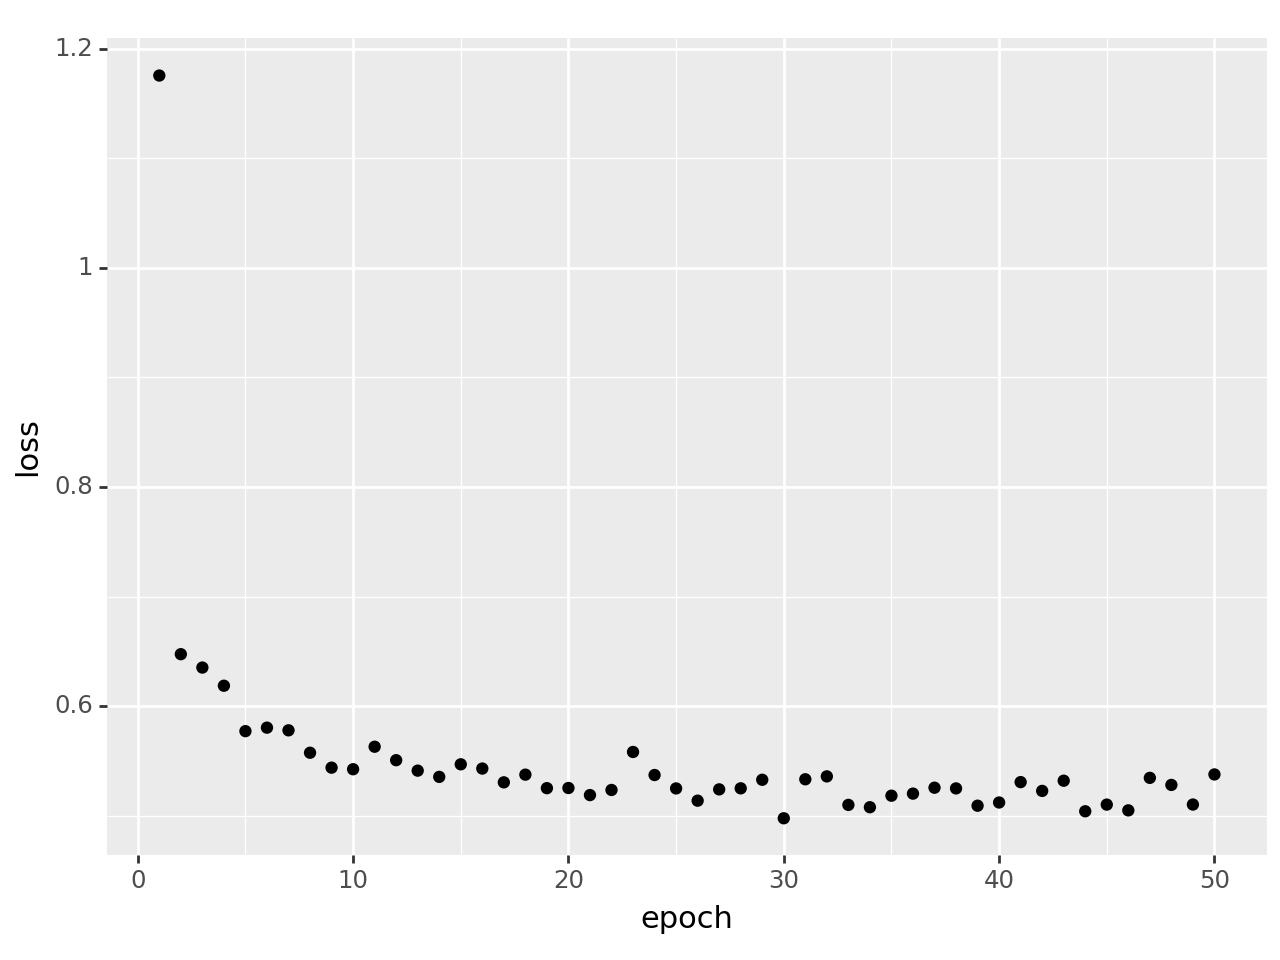

<Figure Size: (640 x 480)>

In [35]:
# see what information has been logged during the training process
simple_nn.history.history.keys()

# plot the training loss over epochs
loss_df = pd.DataFrame(simple_nn.history.history['loss'])
loss_df.columns = ['loss']
loss_df = loss_df.assign(epoch = np.arange(1, 51))

(
    ggplot(loss_df, aes(x='epoch', y='loss')) +
    geom_point()
)

**Conclusion:** We can see on this graph that the loss os going down the more epochs the data is trained on. But the loss is going down quite quickly in the beginning and then only slowly and in the end barely more. 
Initially, the model's predictions is far from the actual values, leading to a higher loss. With each epoch, the model fine-tunes its parameters, gradually improving its ability to make accurate predictions.

### 4.2.2 Evaluate on validation dataset

In [36]:
# Training the neural network with validation data using the fit method
simple_nn.fit(X_train_set, y_train_set, epochs=50, batch_size = 20, validation_data=(X_train_validation, y_train_validation))

Epoch 1/50
287/287 [==============================] - 3s 9ms/step - loss: 0.5100 - val_loss: 1.1667
Epoch 2/50
287/287 [==============================] - 3s 9ms/step - loss: 0.4989 - val_loss: 1.1584
Epoch 3/50
287/287 [==============================] - 3s 9ms/step - loss: 0.4973 - val_loss: 1.2168
Epoch 4/50
287/287 [==============================] - 2s 8ms/step - loss: 0.5142 - val_loss: 1.1545
Epoch 5/50
287/287 [==============================] - 2s 8ms/step - loss: 0.5370 - val_loss: 1.1412
Epoch 6/50
287/287 [==============================] - 2s 8ms/step - loss: 0.5315 - val_loss: 1.1151
Epoch 7/50
287/287 [==============================] - 2s 8ms/step - loss: 0.5122 - val_loss: 1.1170
Epoch 8/50
287/287 [==============================] - 2s 8ms/step - loss: 0.5205 - val_loss: 1.1563
Epoch 9/50
287/287 [==============================] - 2s 8ms/step - loss: 0.5208 - val_loss: 1.1892
Epoch 10/50
287/287 [==============================] - 2s 8ms/step - loss: 0.4856 - val_loss: 1.1316

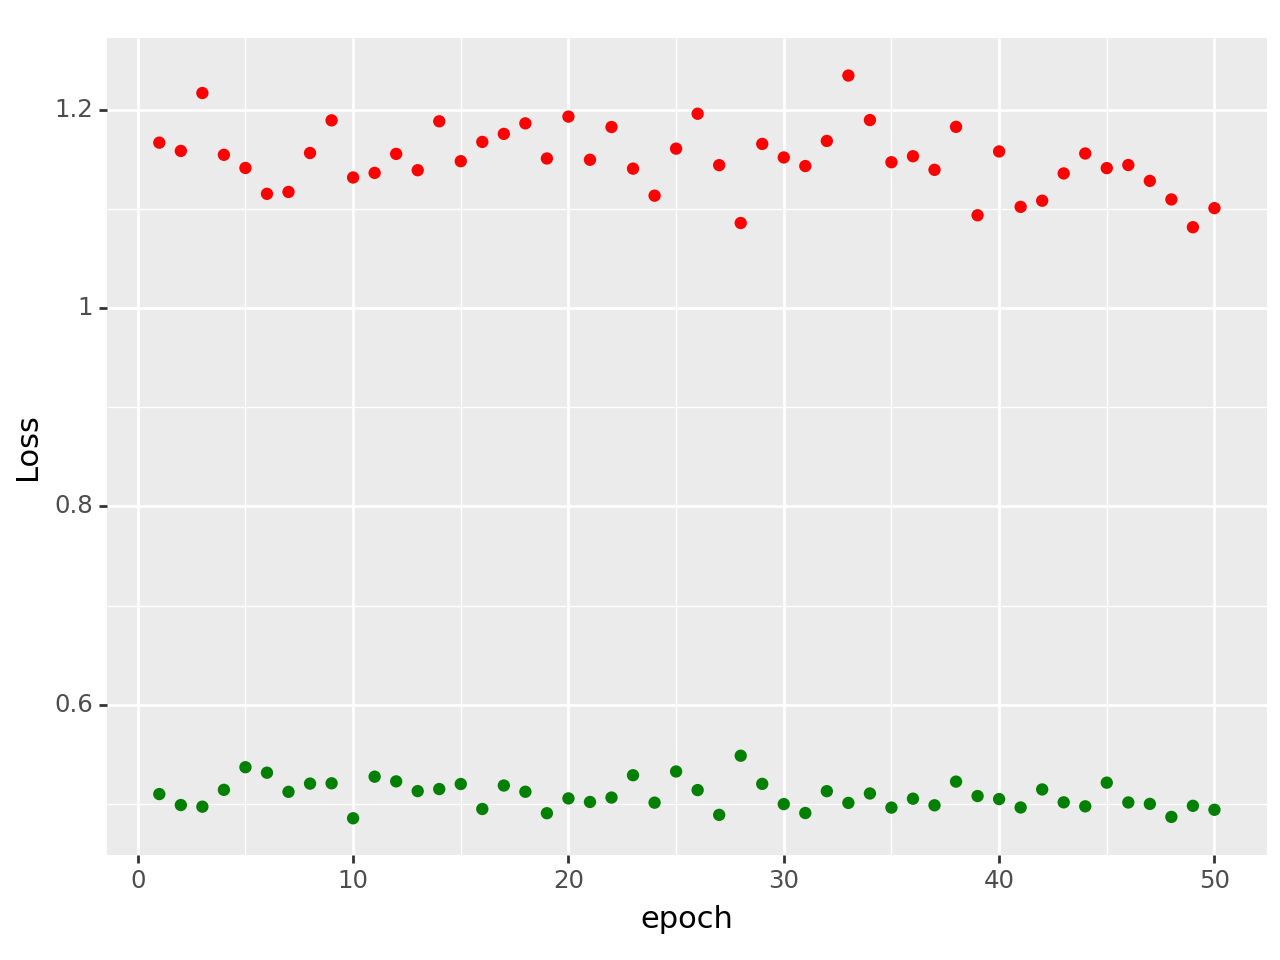

<Figure Size: (640 x 480)>

In [37]:
from plotnine import ggplot, aes, geom_point, scale_x_continuous, labs

# Define a function to plot training and validation loss over epochs
def plot_loss(nn_model):
    # Create a DataFrame with training and validation loss values
    loss_df = pd.DataFrame({
        'train_loss': nn_model.history.history['loss'],
        'val_loss': nn_model.history.history['val_loss']
    })
    
    # Add an 'epoch' column to the DataFrame
    loss_df = loss_df.assign(epoch=np.arange(1, len(loss_df) + 1))

    # Create a ggplot object with points for training and validation loss
    p = (
        ggplot(loss_df) +
        geom_point(aes(x='epoch', y='train_loss'), color='green') +
        geom_point(aes(x='epoch', y='val_loss'), color='red') +
        scale_x_continuous(breaks=list(range(0, len(loss_df), 10))) +
        labs(y="Loss")
    )
    return p

# Call the function with the trained neural network model
plot_loss(simple_nn)


In [38]:
# Save the trained neural network model to a file
simple_nn.save('../dataset/simple_nn_model')

# Store the fitting history of the simple neural network to disk in JSON format
print("Storing the fitting history of simple nn to disk")
with open('../dataset/simple_nn_history.json', 'w') as handle:
    json.dump(simple_nn.history.history, handle)

INFO:tensorflow:Assets written to: ../dataset/simple_nn_model\assets


INFO:tensorflow:Assets written to: ../dataset/simple_nn_model\assets


Storing the fitting history of simple nn to disk


### 4.2.3 Train model on train & validation dataset and make predictions on test set

In [39]:
# showing the y of the test set. This variable contains the true or actual target values corresponding to the test set.
y_test_set

array([[-0.44757312],
       [ 6.27346098],
       [-0.13501882],
       ...,
       [-0.24899046],
       [-0.42454713],
       [-0.18821449]])

In [41]:
# Create the model
final_nn = Sequential()

# Add the first layer 
final_nn.add(Dense(64, input_dim=X_train_set.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.03))) 

# Adding a hidden layer 
final_nn.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.03)))  

# Adding a hidden layer
final_nn.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.03)))  

# Add the output layer
final_nn.add(Dense(1, activation='linear'))

# Configure the Adam optimizer with a custom learning rate
adam = Adam(learning_rate=0.01)

# Compile the model
final_nn.compile(loss='mean_squared_error', optimizer=adam)

# Train the neural network
final_nn.fit(X_train_validation, y_train_validation, epochs=50, batch_size=20, verbose=0)

history = final_nn.fit(X_train_validation, y_train_validation, epochs=50, batch_size=20, verbose=0)

# Make predictions on the test set
y_hat_test_nn = final_nn.predict(X_test_set)

# Calculate Mean Squared Error (MSE) between actual and predicted values
mse_nn = mean_squared_error(y_test_set, y_hat_test_nn)
print("Mean Squared Error:", mse_nn)

# Calculate Mean Absolute Error (MAE) between actual and predicted values
mae_nn = mean_absolute_error(y_test_set, y_hat_test_nn)
print("Mean Absolute Error:", mae_nn)

# Calculate Root Mean Squared Error (RMSE) between actual and predicted values
rmse_nn = np.sqrt(mean_squared_error(y_test_set, y_hat_test_nn))
print("Root Mean Squared Error:", rmse_nn)

# Calculate R-squared (coefficient of determination) between actual and predicted values
r_squared_nn = r2_score(y_test_set, y_hat_test_nn)
print("R-squared:", r_squared_nn)


57/57 [==============================] - 0s 4ms/step
Mean Squared Error: 0.4577167536465578
Mean Absolute Error: 0.2667233719979743
Root Mean Squared Error: 0.6765476728557699
R-squared: 0.5422832463534423


Mean Squared Error: 0.4577167536465578

Mean Absolute Error: 0.2667233719979743

Root Mean Squared Error: 0.6765476728557699

R-squared: 0.5422832463534423

Conclusion:

Mean Squared Error (MSE): The MSE of 0.4577 suggests that the model's predictions deviate, on average, by approximately 0.4577 squared units from the true values. This low value suggests that, on average, the squared errors between predictions and actual values are relatively small.

Mean Absolute Error (MAE): The MAE of 0.2667 suggests that, on average, the model's predictions deviate by approximately 0.2667 units from the true values. This indicates that, on average, the absolute errors between predictions and actual values are relatively small.

Root Mean Squared Error (RMSE): The RMSE of 0.6765 suggests that, on average, the model's predictions differ by approximately 0.6765 units from the true values.

An R-squared of 0.5423 means that approximately 54.23% of the variance in the dependent variable is explained by the independent variables included in your model. Therefore, the model accounts for a moderate amount of the variability in the target variable.

The MSE, MAE, and RMSE values suggest that, on average, the model's predictions have relatively small errors.
The R-squared value indicates that the model explains a moderate proportion (54.23%) of the variance in the dependent variable.

### 4.2.4 Hyperparametertuning

To improve the models performance, hyperparametertuning will be performed.

First on epochs, batch size on number of neurons.

Epoch:  An epoch refers to one complete pass through the entire training dataset. During each epoch, the model processes all training examples, makes predictions, computes the loss, and updates its parameters to minimize the loss.

Batch size: The batch size is a hyperparameter that defines the number of training examples utilized in one iteration (one forward and one backward pass) during the training process of a neural network.

Number of neurons: The number of neurons (or units) in a layer represents the dimensionality of the layer's output space.

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import regularizers
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor

# Define the model creation function
def create_model(layers=2, neurons=256, learning_rate=0.01):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_set.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.03)))

    for _ in range(layers):
        model.add(Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(0.03)))

    model.add(Dense(1, activation='linear'))
    
    adam = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=adam)
    
    return model

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'epochs': [100, 150],
    'batch_size': [10, 20],
    'neurons': [20, 30]
}

# Create the KerasRegressor wrapper for scikit-learn
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the scoring metrics
scoring = {
    'mse': make_scorer(mean_squared_error),
    'mae': make_scorer(mean_absolute_error),
    'rmse': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    'r2': make_scorer(r2_score)
}

# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, refit='mse', cv=3, verbose=1)
grid_result = grid.fit(X_train_validation, y_train_validation)

# Print the best parameters and results
print("Best Parameters:", grid_result.best_params_)
print("Best MSE:", grid_result.best_score_)
print("Best MAE:", grid_result.cv_results_['mean_test_mae'][grid_result.best_index_])
print("Best RMSE:", grid_result.cv_results_['mean_test_rmse'][grid_result.best_index_])
print("Best R-squared:", grid_result.cv_results_['mean_test_r2'][grid_result.best_index_])


C:\Users\leath\AppData\Local\Temp\ipykernel_11372\1012368925.py:33: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'batch_size': 10, 'epochs': 100, 'neurons': 20}
Best MSE: 0.6136306197081004
Best MAE: 0.33813482750904483
Best RMSE: 0.767455874917408
Best R-squared: 0.3945467665444465


Best Parameters: {'batch_size': 10, 'epochs': 100, 'neurons': 20}

Best MSE: 0.6136306197081004

Best MAE: 0.33813482750904483

Best RMSE: 0.767455874917408

Best R-squared: 0.3945467665444465


Before evaluating the measures, another hyperparametertuning will be done for number of layers and learning rate.

Number of layers: The number of layers in a neural network refers to the count of distinct layers, such as input layers, hidden layers, and output layers. Each layer contains a certain number of neurons or units, and these layers are connected by weights.

Learning rate: The learning rate controls the size of the steps taken during the optimization process. It determines how much the model's parameters (weights and biases) are updated in the direction that minimizes the loss function.

In [56]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

# Define a function to create the model
def create_model(layers=2, neurons_per_layer=20, learning_rate=0.01, l2_reg=0.03):
    model = Sequential()
    model.add(Dense(neurons_per_layer, input_dim=X_train_set.shape[1], activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    
    for _ in range(layers - 1):
        model.add(Dense(neurons_per_layer, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    
    model.add(Dense(1, activation='linear'))
    
    adam = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=adam)
    
    return model

# Create a KerasRegressor with the create_model function
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

# Define the hyperparameters to search
param_grid = {
    'layers': [2, 3],
    'learning_rate': [0.001, 0.01],
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit the GridSearchCV object to the training data
grid_result = grid.fit(X_train_validation, y_train_validation)

# Print the best parameters and corresponding mean test score
print("Best parameters found: ", grid_result.best_params_)
print("Lowest RMSE found: ", np.sqrt(-grid_result.best_score_))

# Get the best model
best_model = grid_result.best_estimator_

# Make predictions on the test set using the best model
y_hat_test_best = best_model.predict(X_test_set)

# Calculate metrics with the best model
mse_best = mean_squared_error(y_test_set, y_hat_test_best)
mae_best = mean_absolute_error(y_test_set, y_hat_test_best)
rmse_best = np.sqrt(mse_best)
r_squared_best = r2_score(y_test_set, y_hat_test_best)

# Print metrics
print("Best Model Mean Squared Error:", mse_best)
print("Best Model Mean Absolute Error:", mae_best)
print("Best Model Root Mean Squared Error:", rmse_best)
print("Best Model R-squared:", r_squared_best)

KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters found:  {'layers': 2, 'learning_rate': 0.001}
Lowest RMSE found:  0.5331591714781048
Best Model Mean Squared Error: 0.288263849641602
Best Model Mean Absolute Error: 0.20691078658030257
Best Model Root Mean Squared Error: 0.5369020857117264
Best Model R-squared: 0.7117361503583981


Best parameters found:  {'layers': 2, 'learning_rate': 0.001}

Lowest RMSE found:  0.5331591714781048

Best Model Mean Squared Error: 0.288263849641602

Best Model Mean Absolute Error: 0.20691078658030257

Best Model Root Mean Squared Error: 0.5369020857117264

Best Model R-squared: 0.7117361503583981

### 4.2.5 Evaluate model

The best parameters on batch size, number of epochs, number of neurons, number of layers and learning rate were found and now used to build the final model and evaluate it´s performance.

In [57]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import regularizers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Create the model
final_nn = Sequential()

# Add the first layer 
final_nn.add(Dense(20, input_dim=X_train_set.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.03))) 

# Adding a hidden layer 
final_nn.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.03)))  

# Adding a hidden layer
final_nn.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.03)))  

# Add the output layer
final_nn.add(Dense(1, activation='linear'))

# Configure the Adam optimizer with a custom learning rate
adam = Adam(learning_rate=0.001)

# Compile the model
final_nn.compile(loss='mean_squared_error', optimizer=adam)

# Train the neural network with the best parameters
final_nn.fit(X_train_validation, y_train_validation, epochs=100, batch_size=10, verbose=0)

# Make predictions on the test set
y_hat_test_nn = final_nn.predict(X_test_set)

# Calculate Mean Squared Error (MSE) between actual and predicted values
mse_nn = mean_squared_error(y_test_set, y_hat_test_nn)
print("Mean Squared Error:", mse_nn)

# Calculate Mean Absolute Error (MAE) between actual and predicted values
mae_nn = mean_absolute_error(y_test_set, y_hat_test_nn)
print("Mean Absolute Error:", mae_nn)

# Calculate Root Mean Squared Error (RMSE) between actual and predicted values
rmse_nn = np.sqrt(mean_squared_error(y_test_set, y_hat_test_nn))
print("Root Mean Squared Error:", rmse_nn)

# Calculate R-squared (coefficient of determination) between actual and predicted values
r_squared_nn = r2_score(y_test_set, y_hat_test_nn)
print("R-squared:", r_squared_nn)


57/57 [==============================] - 1s 5ms/step
Mean Squared Error: 0.2808645567458657
Mean Absolute Error: 0.21354033491447408
Root Mean Squared Error: 0.5299665619129812
R-squared: 0.7191354432541344


Mean Squared Error (MSE): The MSE of 0.2809 indicates that, on average, the squared errors between predictions and actual values are relatively small. The MSE decreased after hyperparameter tuning, indicating that the model's predictions have lower squared errors compared to the original configuration.

Mean Absolute Error (MAE): The MAE of 0.2135 suggests that, on average, the absolute errors between predictions and actual values are relatively small. The MAE also decreased after tuning, indicating a reduction in the average absolute errors between predictions and actual values.

Root Mean Squared Error (RMSE): The RMSE of 0.5300 suggests that, on average, the model's predictions differ by approximately 0.5300 units from the true values. The RMSE decreased, suggesting an improvement in the average magnitude of the prediction errors.

R-squared (R²): The R-squared of 0.7191 indicates that approximately 71.91% of the variance in the dependent variable is explained by the model. The R-squared value increased after hyperparameter tuning, indicating a higher proportion of variance explained by the model.

The low values of MSE, MAE, and RMSE suggest that, on average, the model's predictions have relatively small errors.
The higher R-squared value indicates a substantial ability of the model to explain the variance in the dependent variable.

Also, the model's performance significantly improved after hyperparameter tuning. The reduction in MSE, MAE, and RMSE, along with the increase in R-squared, indicates improved accuracy and explanatory power of the tuned model.

<Figure size 1600x600 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Actual Profit')

Text(0, 0.5, 'Predicted Profit')

Text(0.5, 1.0, 'Actual vs Predicted Profit Scatterplot with Perfect Prediction Line')

<Axes: >

Text(0.5, 0, 'Predicted Values')

Text(0, 0.5, 'Residuals')

Text(0.5, 1.0, 'Residual Plot')

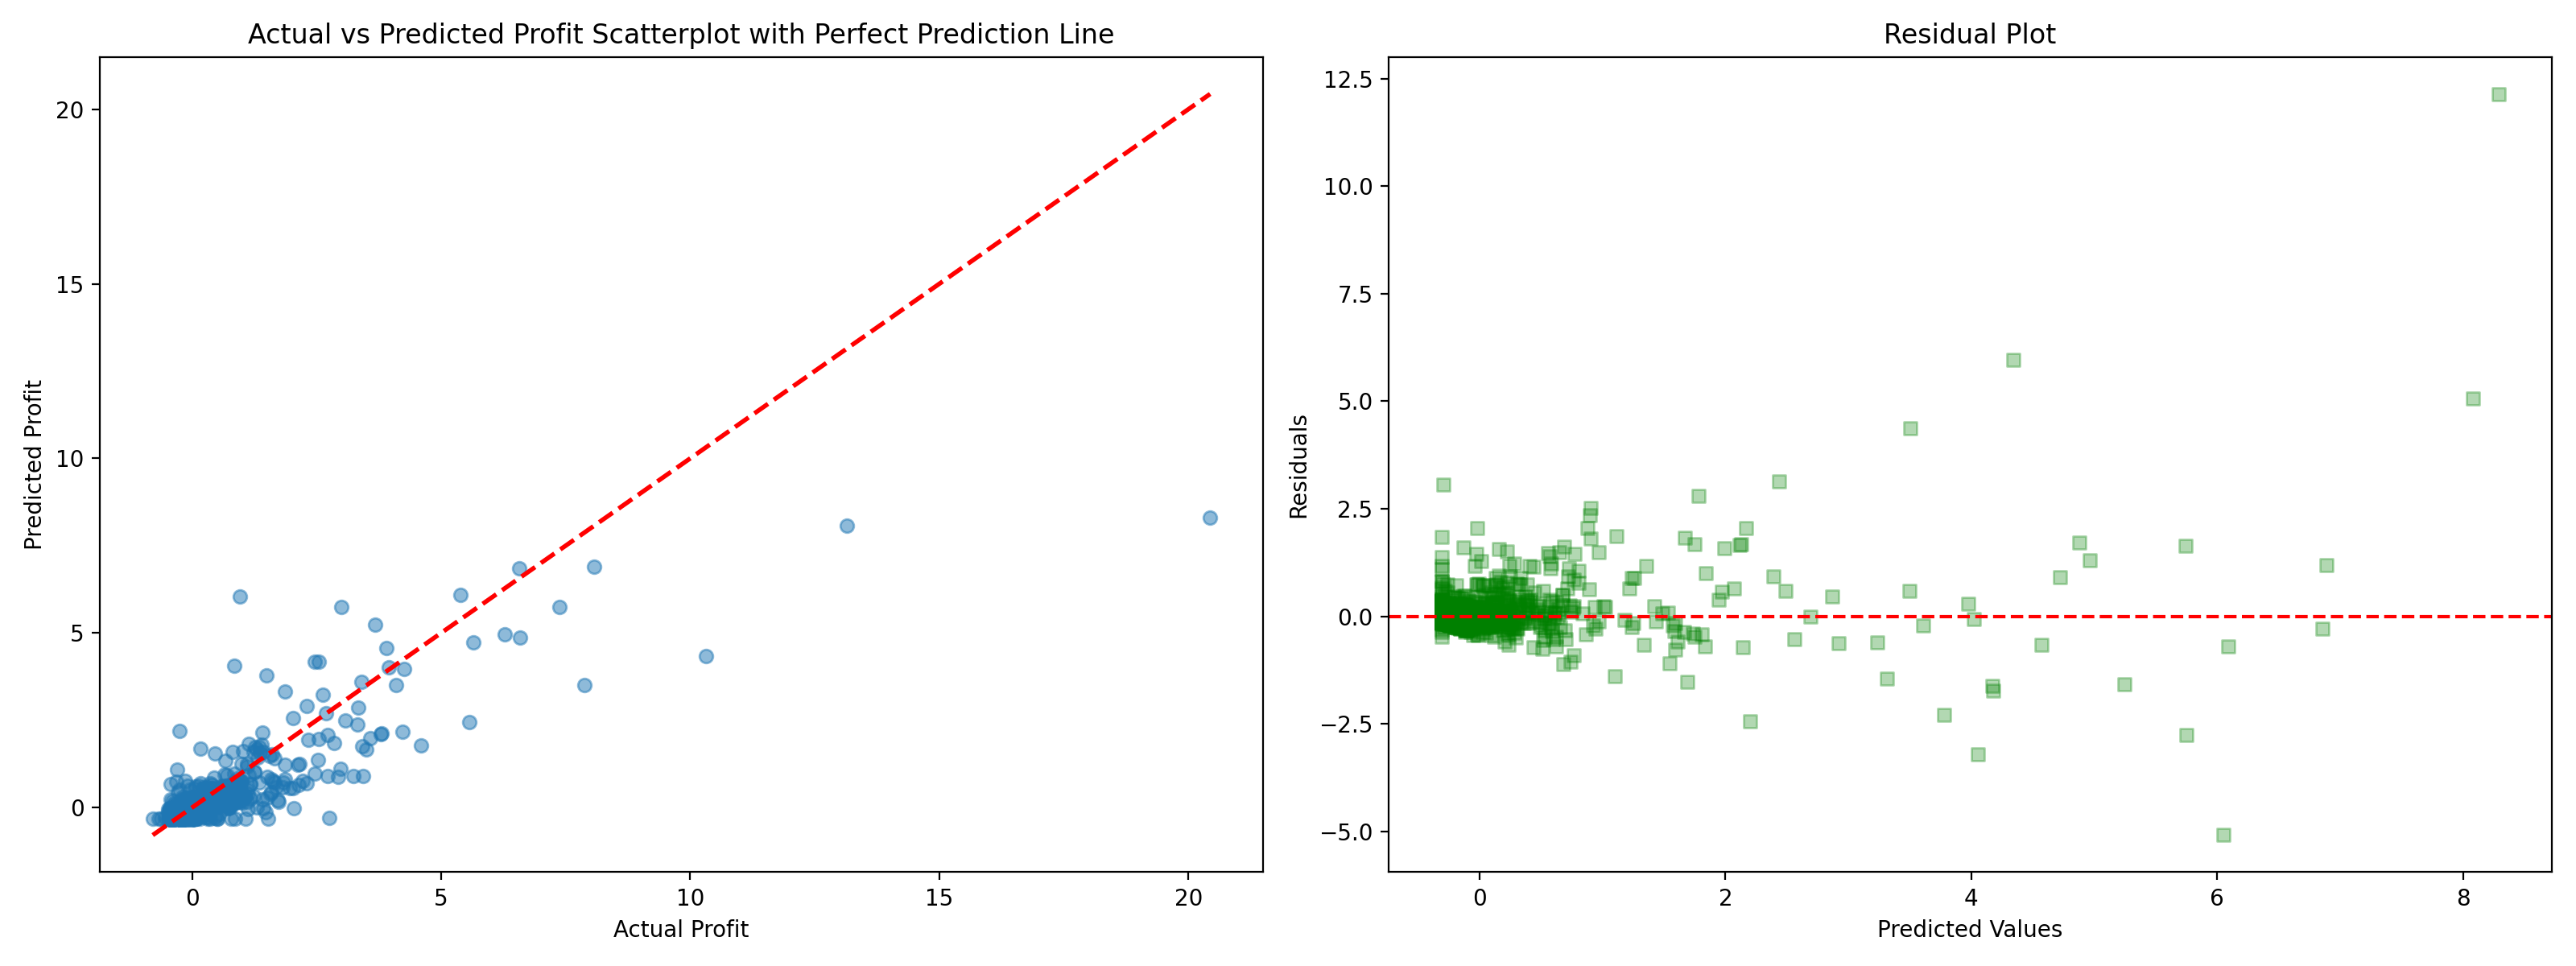

In [79]:
# Plotting actual vs predicted values in a scatterplot
plt.figure(figsize=(16, 6))

# Subplot 1: Scatterplot
plt.subplot(1, 2, 1)
plt.scatter(y_test_set, y_hat_test_nn, alpha=0.5)
plt.plot([min(y_test_set), max(y_test_set)], [min(y_test_set), max(y_test_set)], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Profit')
plt.ylabel('Predicted Profit')
plt.title('Actual vs Predicted Profit Scatterplot with Perfect Prediction Line')

# Subplot 2: Residual Plot
plt.subplot(1, 2, 2)
residuals = y_test_set - y_hat_test_nn
plt.scatter(y_hat_test_nn, residuals, alpha=0.3, color='green', marker='s')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')  
plt.title('Residual Plot')

plt.tight_layout()  
plt.show()

**Conclusion:**

Actual vs. predicted profit Plot: The model seems to tend to predict more lower profit than it actually is, if the profit is really high. 

Residual Plot: Residuals are the differences between the observed values and the predicted values from the model. In this plot, we observe a somewhat random scatter of residuals, suggesting that the model predictions are not biased, which means, they are neither systematically too high nor too low. However, there are a few outliers, particularly for higher predicted values, which may indicate that the model does not capture all of the variability in the data, especially at the higher end of the range of predictions.

# 5. Explainability

When comparing the evaluation metrices of both models, it is visible that the Artificial Neural Network (r-squared = 72%) performs better than the Random Forest (r-squared = 67%). Therefore, the effect of features will be evaluated only on the best performing model, the ANN, in the next section.

In [59]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [60]:
from alibi.explainers import ALE, plot_ale

## 5.1 ALE plots

<Figure size 800x600 with 0 Axes>

Text(0.07791907680034638, 0, '0.0759')

Text(0.06835087728500366, 1, '0.0664')

Text(0.03701496091485024, 2, '0.0350')

Text(0.029100879698991777, 3, '0.0271')

Text(0.02618705262243748, 4, '0.0242')

Text(0.019155829817056658, 5, '0.0172')

Text(0.01610719193518162, 6, '0.0141')

Text(0.015490584678947926, 7, '0.0135')

Text(0.012044191032648087, 8, '0.0100')

Text(0.01194786899536848, 9, '0.0099')

Text(0.5, 0, 'Importance Score')

Text(0, 0.5, 'Features')

Text(0.5, 1.0, 'Top 10 Feature Importance Score for ANN')

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]),
 [Text(0.0, 0, '0.00'),
  Text(0.01, 0, '0.01'),
  Text(0.02, 0, '0.02'),
  Text(0.03, 0, '0.03'),
  Text(0.04, 0, '0.04'),
  Text(0.05, 0, '0.05'),
  Text(0.06, 0, '0.06'),
  Text(0.07, 0, '0.07'),
  Text(0.08, 0, '0.08')])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'genre_Documentary'),
  Text(0, 1, 'genre_Comedy'),
  Text(0, 2, 'genre_Action/Adventure'),
  Text(0, 3, 'rating_ TV-G'),
  Text(0, 4, 'genre_Drama'),
  Text(0, 5, 'avg run per theatre'),
  Text(0, 6, 'genre_Horror'),
  Text(0, 7, 'rating_ Not Rated'),
  Text(0, 8, 'genre_Other'),
  Text(0, 9, 'rating_ NR')])

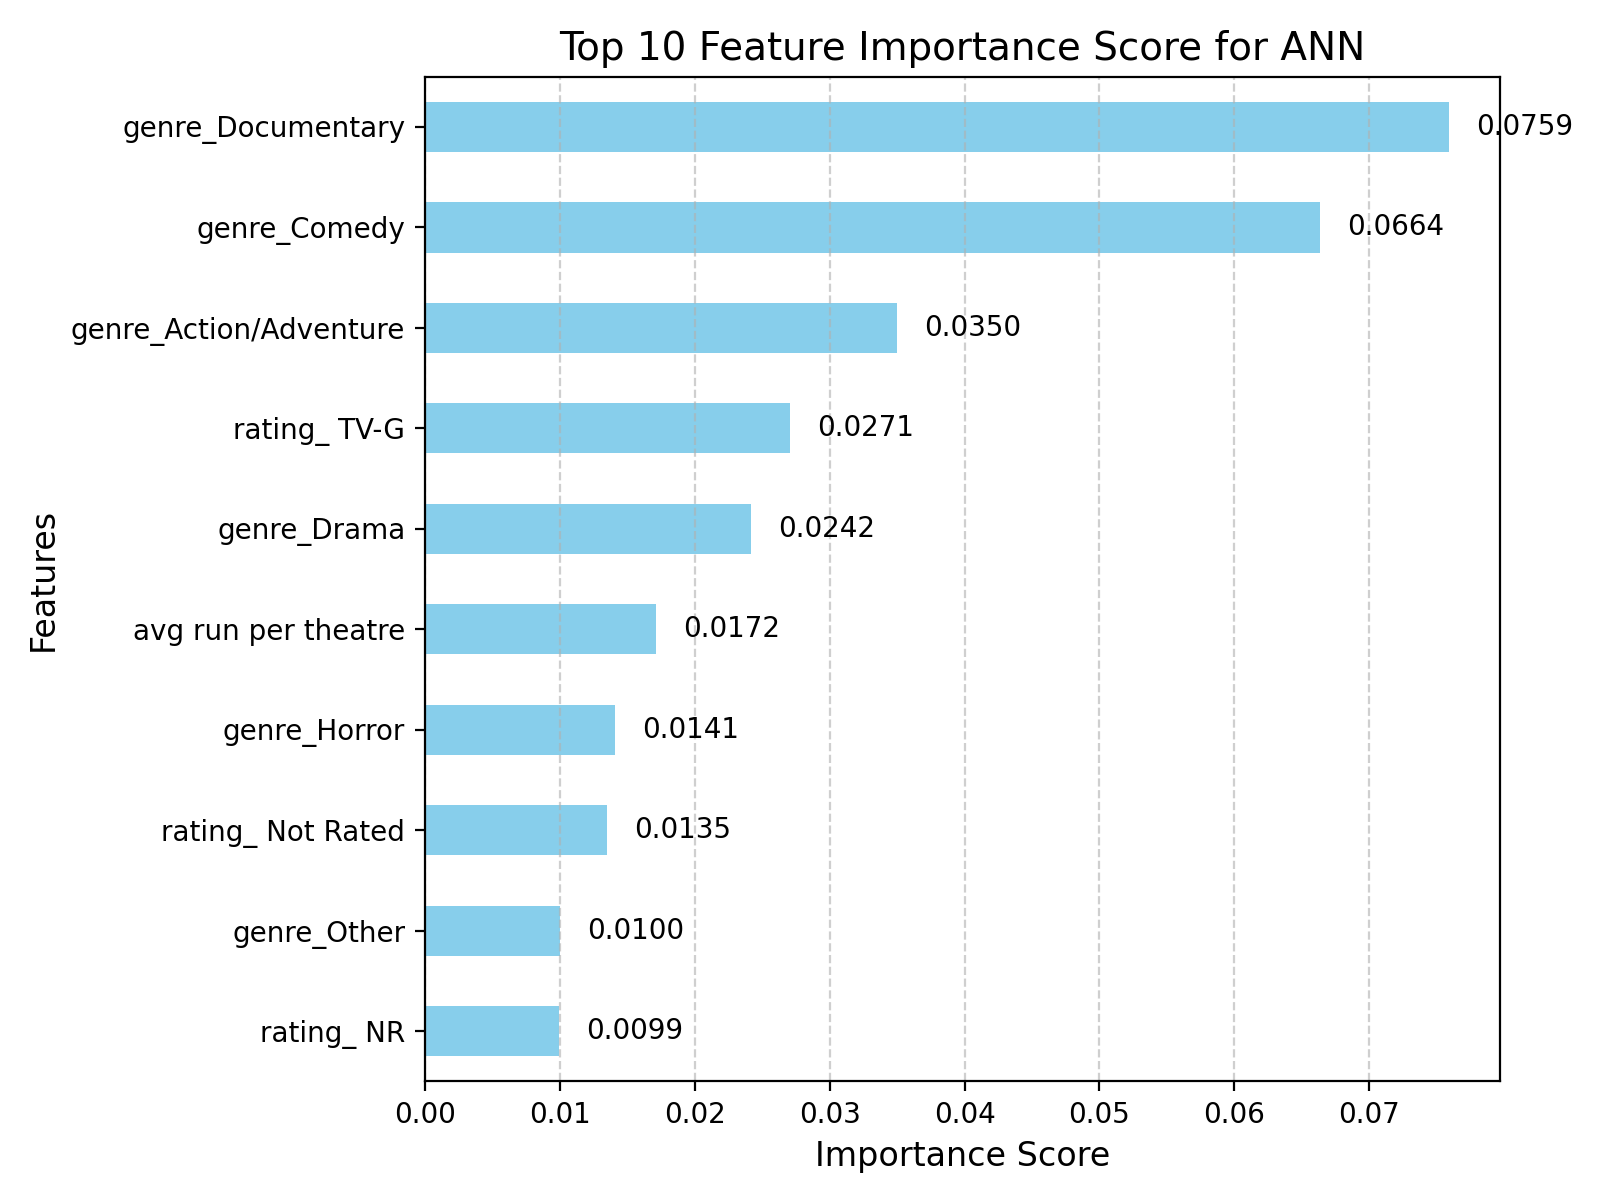

In [81]:
# Extracting the weights from the layers
weights = final_nn.get_weights()

# Extracting the weights of the first layer (assuming it's a dense layer)
dense_layer_weights = np.array(weights[0])

# Get feature names
feature_names = X_train_set.columns

# Check the number of features in X_train
num_features_in_X_train = X_train_set.shape[1]

# Check if the number of features in X_train matches the number of features in the neural network
num_features_in_nn = dense_layer_weights.shape[0]
if num_features_in_X_train != num_features_in_nn:
    print("Number of neurons in the input layer:", final_nn.layers[0].input_shape[1])
    raise ValueError("Number of features in X_train does not match the number of features in the neural network.")

# Calculating feature importances based on the weights
feature_importance = np.mean(np.abs(dense_layer_weights), axis=1)

# Creating a DataFrame with feature importances
feature_importance_df = pd.Series(feature_importance, index=feature_names, name='Importance')

# Plotting the top 10 important features in a horizontal bar chart
plt.figure(figsize=(8, 6))  # Set the figure size

# Plotting the top 10 important features in a horizontal bar chart
ax = feature_importance_df.nlargest(10).plot(kind='barh', color='skyblue')

# Display importance values on the bars
for index, value in enumerate(feature_importance_df.nlargest(10)):
    ax.text(value + 0.002, index, f'{value:.4f}', va='center', fontsize=10, color='black')

# Invert y-axis for better visualization
ax.invert_yaxis()

# Set labels for x and y axes, and the title of the plot
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 10 Feature Importance Score for ANN', fontsize=14)

# Set the font size for the ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add grid lines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

**Conclusion:** Generally it is visible that mostly genres and ratings are represented in the top 10 important features. Therefore, the top features influencing the model are related to the genre of movies and their ratings. Apart from those, only the average run per theatre is on place 6 of the top 10.

The feature "genre_Documentary" has the highest importance score of 0.0759.
This suggests that the presence or absence of documentaries in the dataset significantly influences the model's predictions.

The feature "genre_Comedy" has the second-highest importance score of 0.0664.
The genre of comedy also plays a substantial role in influencing the model's predictions.

The feature "genre_Action/Adventure" has an importance score of 0.0350.
While still important, it has a relatively smaller impact compared to documentary and comedy genres.

TV-G ratings contribute moderately to the model's predictions.

The drama genre also has a moderate impact on the model's predictions.

The average run per theatre contributes to the model's predictions, but to a lesser extent compared to genre-related features.

The horror genre has a smaller but still noticeable impact on the model.

Movies with a "Not Rated" rating contribute lower to the model's predictions.

The "Other" genre, which may include less common genres, contributes but to a lesser degree.

The feature "rating_NR" has the lowest importance score of 0.0099.
The "NR" rating has a relatively smaller impact on the model's predictions.

57/57 [==============================] - 0s 2ms/step


Text(0.5, 0, 'genre_Documentary')

Text(0, 0.5, 'ALE Value')

Text(0.5, 1.0, 'ALE-like Plot for genre_Documentary')

57/57 [==============================] - 0s 1ms/step


Text(0.5, 0, 'genre_Comedy')

Text(0, 0.5, 'ALE Value')

Text(0.5, 1.0, 'ALE-like Plot for genre_Comedy')

57/57 [==============================] - 0s 1ms/step


Text(0.5, 0, 'genre_Action/Adventure')

Text(0, 0.5, 'ALE Value')

Text(0.5, 1.0, 'ALE-like Plot for genre_Action/Adventure')

57/57 [==============================] - 0s 2ms/step


Text(0.5, 0, 'rating_ TV-G')

Text(0, 0.5, 'ALE Value')

Text(0.5, 1.0, 'ALE-like Plot for rating_ TV-G')

57/57 [==============================] - 0s 2ms/step


Text(0.5, 0, 'genre_Drama')

Text(0, 0.5, 'ALE Value')

Text(0.5, 1.0, 'ALE-like Plot for genre_Drama')

57/57 [==============================] - 0s 1ms/step


Text(0.5, 0, 'avg run per theatre')

Text(0, 0.5, 'ALE Value')

Text(0.5, 1.0, 'ALE-like Plot for avg run per theatre')

57/57 [==============================] - 0s 2ms/step


Text(0.5, 0, 'genre_Horror')

Text(0, 0.5, 'ALE Value')

Text(0.5, 1.0, 'ALE-like Plot for genre_Horror')

57/57 [==============================] - 0s 2ms/step


Text(0.5, 0, 'rating_ Not Rated')

Text(0, 0.5, 'ALE Value')

Text(0.5, 1.0, 'ALE-like Plot for rating_ Not Rated')

57/57 [==============================] - 0s 3ms/step


Text(0.5, 0, 'genre_Other')

Text(0, 0.5, 'ALE Value')

Text(0.5, 1.0, 'ALE-like Plot for genre_Other')

57/57 [==============================] - 0s 3ms/step


Text(0.5, 0, 'rating_ NR')

Text(0, 0.5, 'ALE Value')

Text(0.5, 1.0, 'ALE-like Plot for rating_ NR')

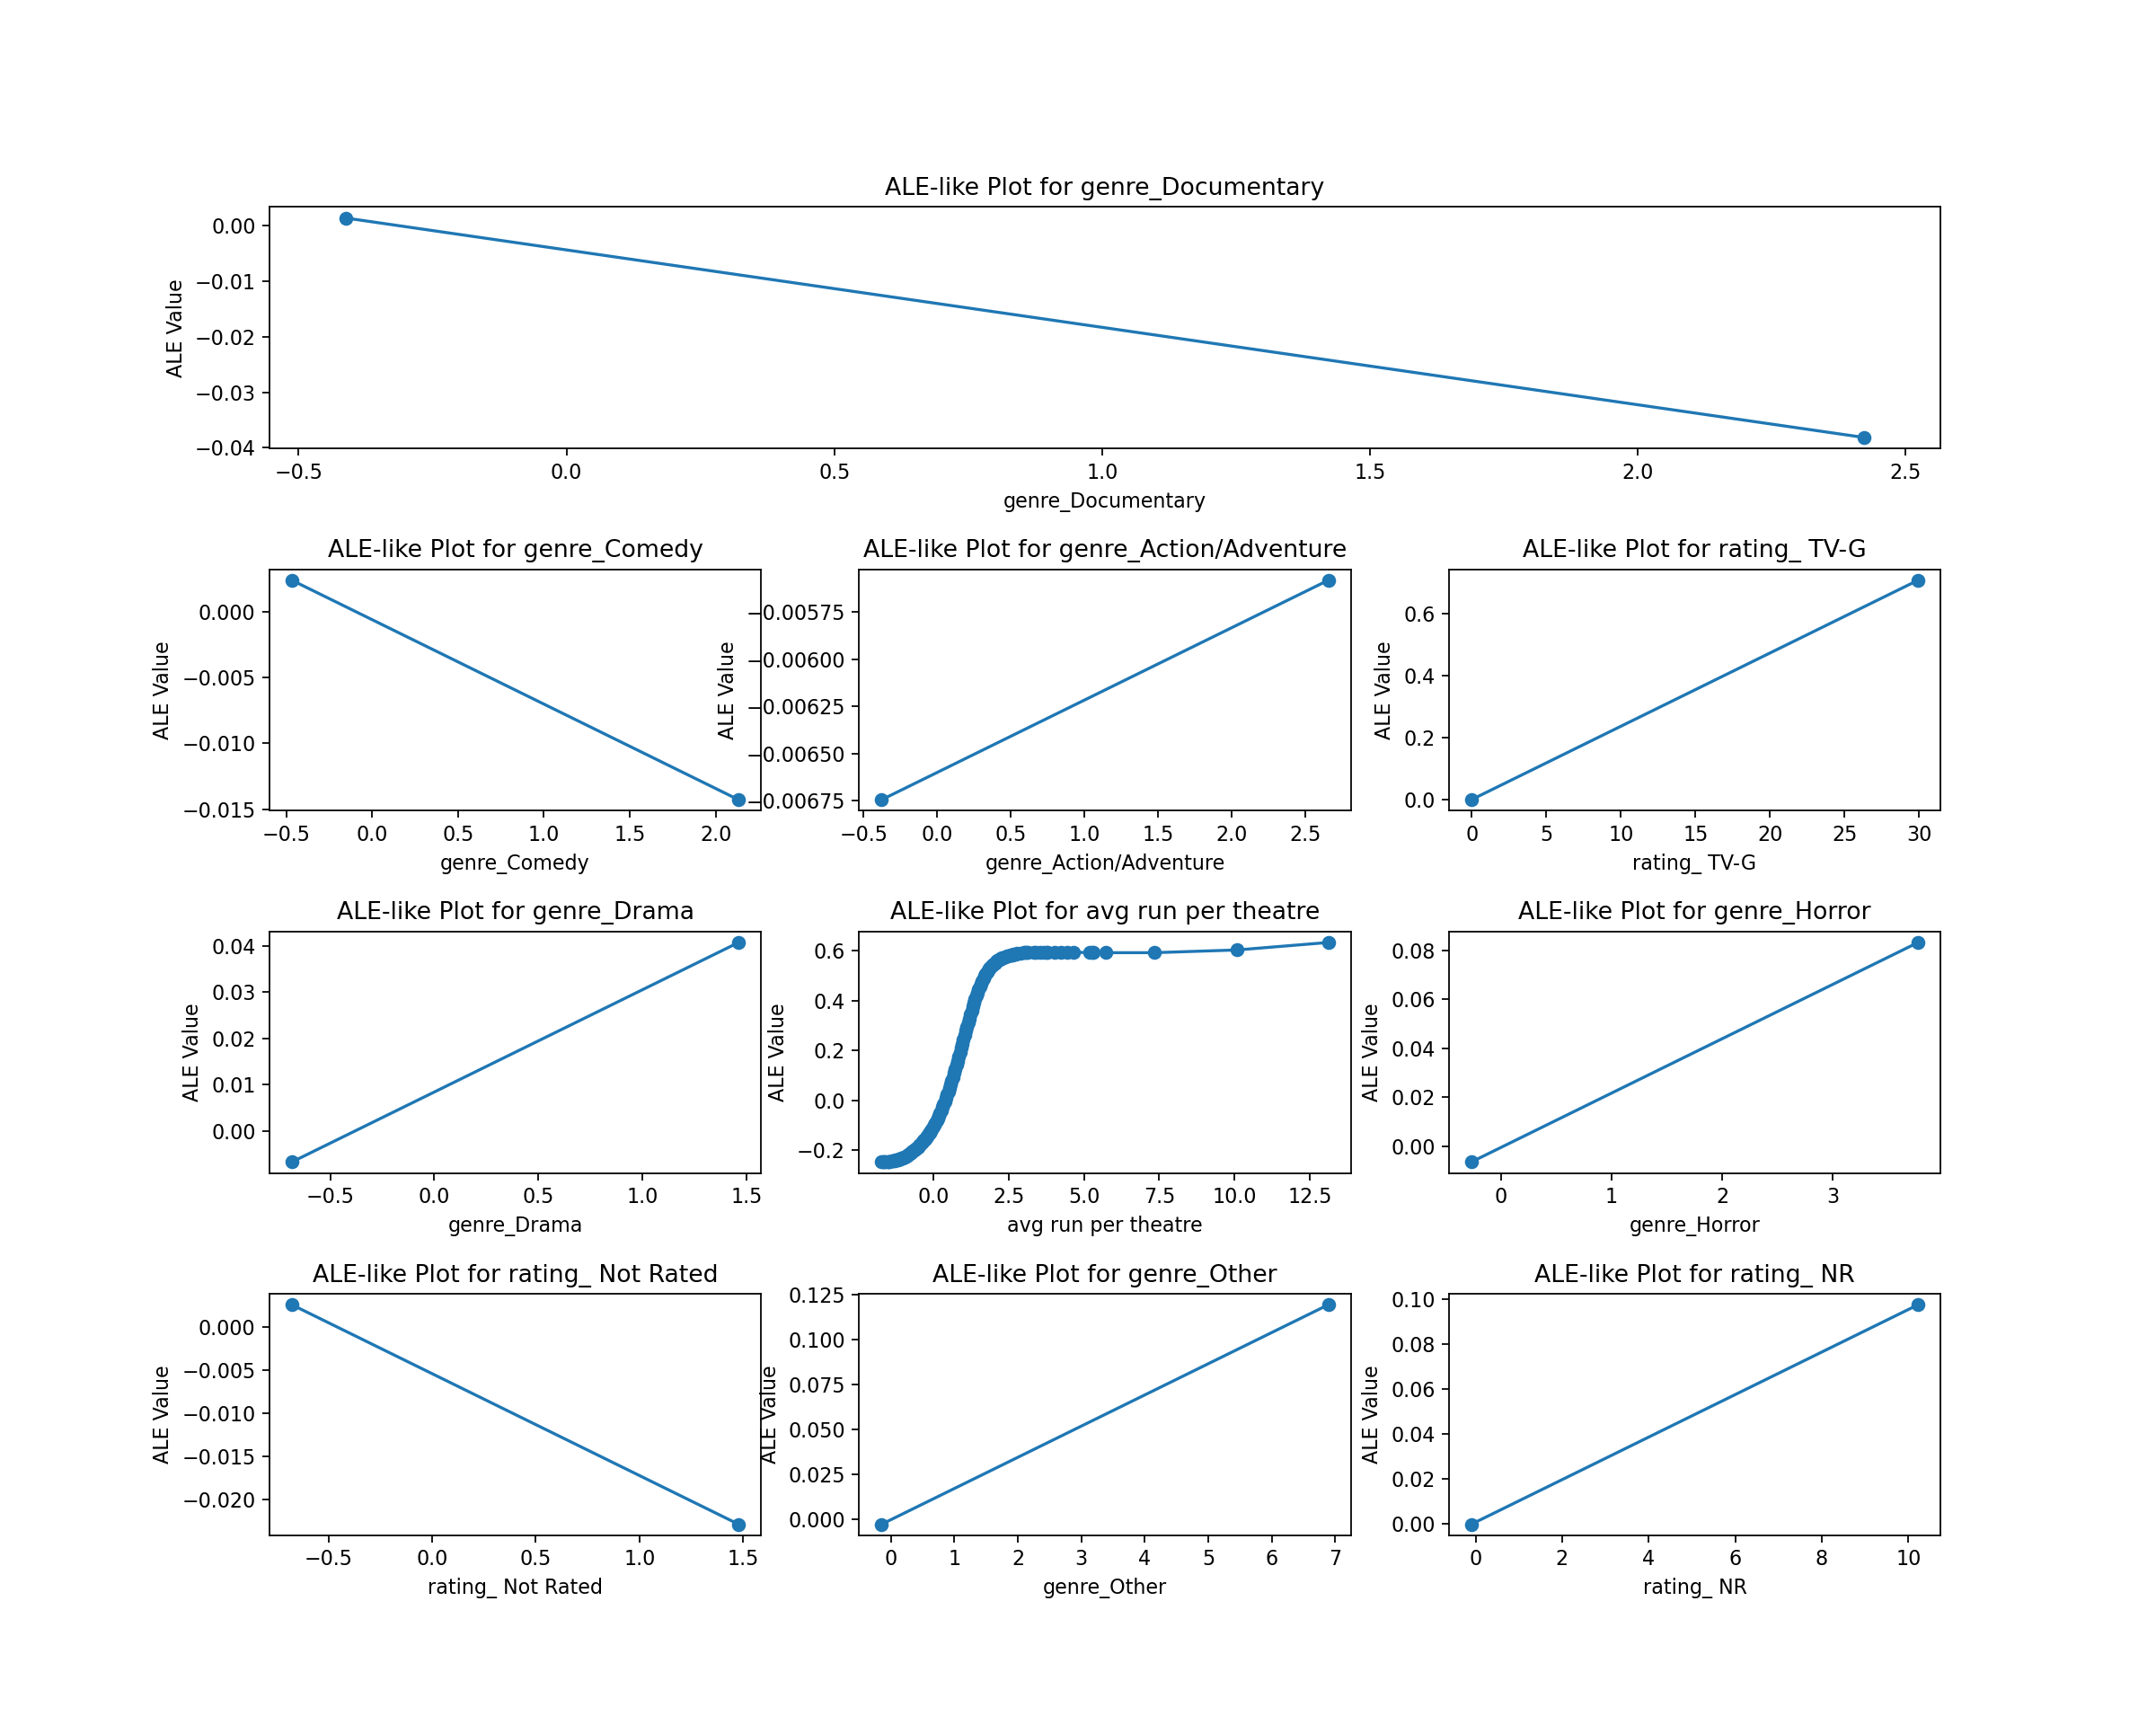

In [96]:
import seaborn as sns
from matplotlib import gridspec

X_test_copy = X_test_set.copy()

# List of features for which to calculate ALE
features_to_calculate_ale = ['genre_Documentary', 'genre_Comedy', 'genre_Action/Adventure',
                              'rating_ TV-G', 'genre_Drama', 'avg run per theatre',
                              'genre_Horror', 'rating_ Not Rated', 'genre_Other', 'rating_ NR']

# Set up the grid layout for subplots
gs = gridspec.GridSpec(4, 3) 
fig = plt.figure(figsize=(15, 12), dpi=80)

# Define subplots
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
ax7 = fig.add_subplot(gs[2, 2])
ax8 = fig.add_subplot(gs[3, 0])
ax9 = fig.add_subplot(gs[3, 1])
ax10 = fig.add_subplot(gs[3, 2])

# Iterate through features and plot ALE-like plots
for i, feature_to_calculate_ale in enumerate(features_to_calculate_ale):
    unique_feature_values = np.sort(X_test_copy[feature_to_calculate_ale].unique())
    ale_values = []

    for value in unique_feature_values:
        # Create a copy of the input data with the current feature value replaced
        X_test_copy_single_plot = X_test_copy.copy()
        X_test_copy_single_plot[feature_to_calculate_ale] = value

        # Make predictions on the modified dataset
        y_hat_test_nn_modified = final_nn.predict(X_test_copy_single_plot)

        # Calculate the ALE value
        ale_value = np.mean(y_hat_test_nn_modified - y_hat_test_nn)
        ale_values.append(ale_value)

    ale_values = np.array(ale_values)

    # Plot in the corresponding subplot
    ax = locals()['ax{}'.format(i + 1)]
    ax.plot(unique_feature_values, ale_values, marker='o')
    ax.set_xlabel(feature_to_calculate_ale)
    ax.set_ylabel("ALE Value")
    ax.set_title(f"ALE-like Plot for {feature_to_calculate_ale}")

# Adjust layout for better spacing and remove excess white space
plt.subplots_adjust(hspace=0.5)  # You can adjust the value as needed
plt.show()


**Conclusion:** 

The presence of the genres Documentary and Comedy and of the rating "Not Rated" have a negative influence on the profit of the movie. On the other hand, the genres Anction/Adventure, Drama, Horror and Other and the rating TV-G have a positive relationship with profit. 

The avg run per theatre plot also shows a strong positive relationship, with the ALE value increasing sharply as the average run per theatre increases. This suggests that movies that have longer runs in theatres tend to be more profitable. A low average amount of runs per theatre has a negative impact on profit. Then with small amounts of more runs per theatre the effect on the profit becomes positive and rises really quickly. At a certain amount more runs do not really have a higher positive impact on the profit. 

## 5.2 Answers to research Question

1 - Which model performs best at predicting profit?

The Neural Network performs better than the Random forest.

2 - Which features are best for predicting profit for movies?

To determine which features are best for predicting movie profit, we typically look for features with the most significant and consistent impact on the ALE value. Also, features with steeper and larger spans on the ALE value in the ALE plots, typically have a more substantial effect on the predicted outcome.The following features have the highest influence on predicting the profit of a movie: 'genre_Documentary', 'genre_Comedy', 'genre_Action/Adventure', 'rating_ TV-G', 'genre_Drama', 'avg run per theatre', 'genre_Horror', 'rating_ Not Rated', 'genre_Other', 'rating_ NR'.

3 - How do certain genre affect the movie´s profit?

Documentary: The ALE plot for documentaries shows a negative trend, suggesting that a movie being a documentary is associated with a decrease in movie profit.

Comedy: There is a slight negative effect on profit for Comedy movies as indicated by the ALE value decreasing.

Action/Adventure: This plot also indicates a slight negative effect on profit.

Drama: Shows a very slight positive effect on profit.

Horror: Exhibits a positive effect on profit, suggesting that horror films are associated with an increase in profit.

Other: Indicates a positive relationship with profit, suggesting that movies falling outside the main listed genres could potentially yield higher profits.

4 - How do certain ratings affect the movie´s profit?

TV-G: The ALE plot shows a strong positive relationship with profit, indicating that movies with this rating may be associated with higher profits.

Not Rated: The plot shows a slight negative relationship with profit.

NR: The plot indicates a strong positive relationship, suggesting that movies with this rating are associated with higher profits.

5 - How does the average run per theatre influence the profit of a movie?

The ALE plot for avg run per theatre shows a positive relationship with movie profit. This suggests that movies with longer average runs per theatre are associated with higher profits. Therefore extending the run of a movie in theatres can positively affect its profit.

**Main Research Question: How should movie studios design their strategy to maximize the profit of their movies?**

Genre Selection: Focus on genres such as Horror, Drama, and Other (outside the main genres), as they show positive or slightly positive effects on profit.

Rating Consideration: Consider obtaining a TV-G or NR rating, as they are associated with a strong positive relationship with profit.

Run Length Emphasis: Prioritize longer runs in theatres, as the positive relationship between average run per theatre and profit suggests that extended theatrical exposure can positively impact movie profit.